## CSYE7245 - Modern Music Genre Classification with large multi-class dataset
                                            Ashutosh Mahala, Xiaosui Zhang

# Background

## Classification of Songs

Classifying the songs can reduce the work for searching for a song. Classification can be done on multiple bases like the genre, mood or keywords related to them.  The most of the common way classify the song is through the genre.

## What is a genre?

A genre is any form or type of communication in any mode with socially-agreed upon conventions developed over time.  The genre is most popular in categorizing the music. Music can be devided into different genres in different ways. Due to subjective nature of the music, it is difficult to categories music in one genre and most of the time genre of the music overlap each other.

## Expectation from the Project

To do build a model which automatically classify the songs through their acoustic features.

## Why did we choose this project?

There have been multiple automatic genre detection studies on multiple feature of audio. However they were either heavily based on methods or on features or the target genre scope is very small. The Dataset we are using for the study is more standard and real world. The dataset $\href{https://github.com/mdeff/fma}{FMA-LTS2}$ has been created from the dump of songs from $\href{http://freemusicarchive.org/}{FMA}$. FMA is a high qaulity liberary which has certain types music for work which would not be available otherwise due to copyright. It has around 106,500 songs with 163 genres and provides features already extracted from the $\href{https://librosa.github.io/librosa/}{LibROSA}$ liberary.

# Let's Start with the Real Work Now

### Data Introduction

FMA: A Dataset For Music Analysis is the dataset comipled from FMA dumped music by Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2. Consists of:
```
1. tracks.csv - This csv contains metadata like track_id, track_id, album_name, release date of 106,574 songs
2. genres.csv - This csv contains 163 genres.
3. features.csv - This csv contains all the features which can be extracted through LibROSA liberary.
4. echonest.csv - This csv contains data like danceablity, valence provided by Echonest(now known as Spotify)
```

In this dataset we maily going to deal with following tables and the columns:
1. tracks.csv: 
<br />    a. track_id: id of the tracks
<br />    b. genre_top: this only contains the name of genre which are only one. A song containing multiple genres will be blank for that perticular song
2. genres:
<br />    a. genre_id: id of genre (This will be our target of prediction for our model)
<br />    b. title: title of genre
3. features

Let's import the liberary needed to run this project

In [2]:
import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import keras
import urllib.request
import zipfile
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# -- Keras Import
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing import image

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU, SimpleRNN

from keras.layers import Activation, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.


Let's set the global variables from where we are going to download the dataset and where we are goin to save these

In [3]:
# Global variables
url_loc = 'https://os.unil.cloud.switch.ch/fma/fma_metadata.zip'
file_loc = './data/fma_metadata.zip'
dir_unzip_loc = './data/'

data_length = 5000

Let's start downloading the data

In [4]:
# Download zipped fma meta data
if not os.path.isfile(file_loc):
    urllib.request.urlretrieve(url_loc, file_loc)

and then unzip it

In [5]:
# Unzip fma meta data
if not os.path.isdir(dir_unzip_loc):
    with zipfile.ZipFile(file_loc, 'r') as zip_ref:
        zip_ref.extractall(dir_unzip_loc)

Now we are going to load these dataset in the pandas dataframes

In [6]:
# We are goint to read the headers seperatly and create an list
feat_header = pd.read_csv(dir_unzip_loc + "fma_metadata/features.csv", header=None, nrows=3)
feat_header = feat_header.transpose(copy = True)
name = []
for index, row in feat_header.iterrows():
    name.append(row[0]+"#"+row[1]+"#"+row[2])
name[0] = "track_id"

#Now read the dataset
df_tracks = pd.read_csv(dir_unzip_loc + "fma_metadata/tracks.csv", skiprows=[0,2]);
df_features = pd.read_csv(dir_unzip_loc + "fma_metadata/features.csv", header = None, names= name ,skiprows=4);
# df_features = pd.read_csv(dir_unzip_loc + "fma_metadata/features.csv", header = None, names= a ,skiprows=4, nrows=data_length);
df_genres = pd.read_csv(dir_unzip_loc + "fma_metadata/genres.csv", skiprows=0, nrows=data_length);

df_tracks = df_tracks.rename(columns={ df_tracks.columns[0]: "track_id" })
df_features = df_features.rename(columns={ df_features.columns[0]: "track_id" })
1

1

Let's check the structure of df_tracks dataframe

In [8]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
track_id             106574 non-null int64
comments             106574 non-null int64
date_created         103045 non-null object
date_released        70294 non-null object
engineer             15295 non-null object
favorites            106574 non-null int64
id                   106574 non-null int64
information          83149 non-null object
listens              106574 non-null int64
producer             18060 non-null object
tags                 106574 non-null object
title                105549 non-null object
tracks               106574 non-null int64
type                 100066 non-null object
active_year_begin    22711 non-null object
active_year_end      5375 non-null object
associated_labels    14271 non-null object
bio                  71156 non-null object
comments.1           106574 non-null int64
date_created.1       105718 non-null object
favorites.1          1065

By looking at the info, we can say following things:
1. track_id column doesn't have any value which is no non numeric value. otherwise it would have parsed as object not as int64. 
1. genre_top column has less number of values, however at the same time genres and genres_all have same value as the track_id which implies if there are no missing values in track_id. Then the genre_top value are the only genres which are only single for one song. Because genre_top only account for the pure genre type of songs while the genre type if for all genres associated with the perticular song. So we are going to focus on this as our classification target.
1. We can see there are 30% of missing values for release date for an album (date_released) which is around 70 percent. Which can fairly give us the idea what period of songs were targeted while making the dataset. 

Let's check if there are any missing values in the track_id

In [9]:
df_tracks.track_id.isnull().sum()

0

As we can see there are no missing values. It looks the track_id has been parsed correctly.
<br /> Now let's have a look at the features table

In [11]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr#std#01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


OMG 519 columns! Look's rather daunting. Allow me to explain 

This data is pretty inflated. The actual number of features are just 10. However, these features have been taken on different time frames of songs. 
<br /> This dataset has column at three level:
    1. Audio feature
    2. Statictical feature: like mean, meadian, min, max
    3. The window: Each song has been devided into 12 parts and then features have been extracted out of them.

We are actaully dealing with the following audio features here:
1. $\href {http://ismir2011.ismir.net/papers/PS2-8.pdf}{Chroma-features}$: chroma_cens, chroma_cqt, chroma_stft
2. $\href{https://en.wikipedia.org/wiki/Mel-frequency_cepstrum} {mfcc}$
3. $\href{https://en.wikipedia.org/wiki/Energy_(signal_processing%29)} {rmse}$: Root-Mean square Energy
4. $\href{https://en.wikipedia.org/wiki/Spectral_centroid} {Sprectral-Centroid}$
5. $\href {https://ieeexplore.ieee.org/document/1035731} {Spectral-Contrast}$
6. $\href {https://ccrma.stanford.edu/~jos/sasp/Spectral_Roll_Off.html} {Spectral-rolloff}$
7. $\href {https://en.wikipedia.org/wiki/Tonnetz} {Tonnetz}$
8. $\href {https://en.wikipedia.org/wiki/Zero_crossing} {zcr}$: Zero cross Rate

If there is any missing value while the feature extraction

In [13]:
df_features.isnull().sum().unique()

array([0])

By looking above we can say that there are no feature which data has net been extracted.

---
### Merging the tables
Takeing only the data which we need for training the model.

In [7]:
df_tracks_only_genre = df_tracks[['genre_top','track_id']]
df_tracks_only_genre_with_id = pd.merge(df_tracks_only_genre, df_genres, left_on="genre_top", right_on="title", how='inner')
df_tracks_only_genre_with_id = df_tracks_only_genre_with_id[['genre_id','track_id']]
df_tracks_only_genre_with_id.head()

,genre_id,track_id
0,21,2
1,21,3
2,21,5
3,21,134
4,21,583


In [8]:
# Merge
df = pd.merge(df_tracks_only_genre_with_id, df_features, on ="track_id", how='inner')
df.head()

,genre_id,track_id,chroma_cens#kurtosis#01,chroma_cens#kurtosis#02,chroma_cens#kurtosis#03,chroma_cens#kurtosis#04,chroma_cens#kurtosis#05,chroma_cens#kurtosis#06,chroma_cens#kurtosis#07,chroma_cens#kurtosis#08,...,tonnetz#std#04,tonnetz#std#05,tonnetz#std#06,zcr#kurtosis#01,zcr#max#01,zcr#mean#01,zcr#median#01,zcr#min#01,zcr#skew#01,zcr#std#01
0,21,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,21,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,21,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,21,134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,...,0.058766,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623
4,21,583,-0.028032,0.509161,0.067235,0.465656,-0.448363,1.086958,-0.103174,-0.247502,...,0.058434,0.018185,0.017061,2.111479,0.270508,0.036760,0.025879,0.000977,1.296176,0.033785


Now it seema we are properly able to merge the tables

### Data Analysis

Now Let's do some data analysis.

First we will check how many genre we are specifically dealing with after merging as it removes the songs which belongs to more than one genre.

In [11]:
df.genre_id.unique().size

16

We can see from 163 genres we are down to 16 only. But let's check how it is distributed.

In [12]:
df["genre_id"].groupby(df["genre_id"]).count().sort_values(ascending=False)

genre_id
12      14182
38      10608
15       9372
21       3552
17       2803
10       2332
1235     2079
2        1389
5        1230
4         571
8         554
20        423
9         194
14        175
3         110
13         24
Name: genre_id, dtype: int64

Seems  we have quite abundance of genre 12 which is "Rock" by the way is the most common.
<br /> we can see our song language distribution as well. which is pretty skewed. English is abundance as this site is english regenal. There will be some language as well as people are from different place or they like to hear different language songs however it should be less in number

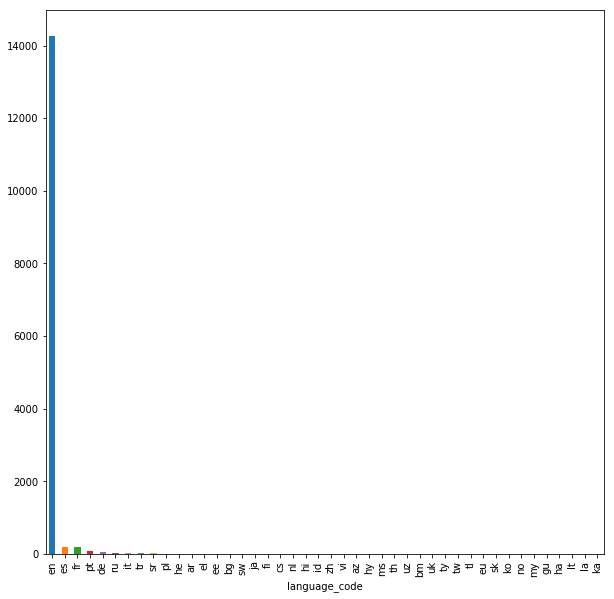

In [14]:
df_tracks["language_code"].groupby(df_tracks["language_code"]).count().sort_values(ascending=False).plot(kind="bar", figsize=[10,10])

Let's check one of the feature RMSE. which is used to check the scielence in the signal. That means the signal which has lower RMSE will hasve more silence in it.

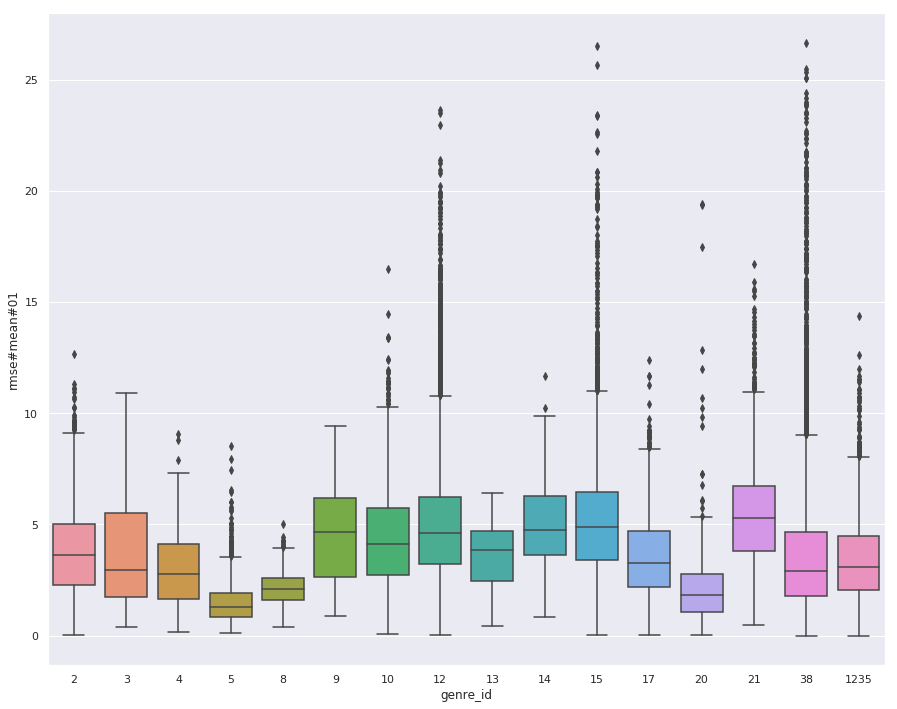

In [15]:
sns.set(rc={'figure.figsize':(15,12)})
sns.boxplot(x="genre_id", y="rmse#mean#01", data=df);

From the above graphs we can see that some songs have more silence in them than the other songs. Here we can see that some genres clearly have more silence in them than the other genres.

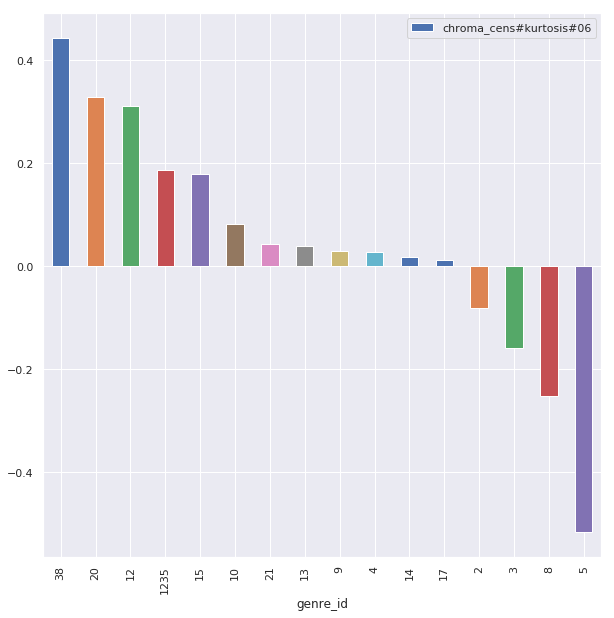

In [16]:
df[["chroma_cens#kurtosis#06","genre_id"]].groupby(df["genre_id"]).mean().sort_values(by = "chroma_cens#kurtosis#06",ascending=False).head(30).plot(x="genre_id", y="chroma_cens#kurtosis#06", kind="bar", figsize=[10,10])

We are looking at the chroma cens feature which relates to the energy in the octave. And the statistical feature are considering here is kurtosis which looks tailness. This means the some songs have lower raising and declining rate in ocatave than the other songs. Which is pretty common in certain types of genre. which clearly differentiate them.

##  Methods - Let's train some models now

We will apply random forest, svm and nerual network(RNN) to the data we have. A 10-fold cross validation will be used and the optimization will be based on grid search with multiple hyperparameters.

### 1. Random Forest

Random forset is the ensemble method of multiple classification desision tree and linear regression. We train maultiple descision trees and then enseble them for their end result.
![image.svg](https://dimensionless.in/wp-content/uploads/RandomForest_blog_files/figure-html/intro.jpg)

Let's train our first model which is Random Forest

In [12]:
n_max = 0
msl_max = 0
mf_max = 0
acc_max = 0

print ("Processing FMA data upon Random Forest, hyperparameters are [n_estimators, min_samples_leaf, max_features]")

for n in [100, 500]:
    for msl in [5, 20]:
        for mf in [3, 10]:
            # Build the model
            rf = RandomForestClassifier(n_estimators = n,
                                        min_samples_leaf=msl,
                                        max_features=mf,                                        
                                        criterion='gini',)
            m = rf.fit(X_train, Y_train)
            Y_pred = m.predict(X_test)
            acc = metrics.accuracy_score(Y_test, Y_pred)
            print("Random forest with [%r, %r, %r] gets accuracy %r " % (
                n, msl, mf, acc))
            if acc_max < acc:
                  acc_max = acc
                  n_max = n
                  msl_max = msl
                  mf_max = mf
                

print("Best random forest with [%r, %r, %r] gets accuracy %r " % (
    n_max, msl_max, mf_max, acc_max))

Processing FMA data upon Random Forest, hyperparameters are [n_estimators, min_samples_leaf, max_features]
Random forest with [100, 5, 3] gets accuracy 0.25263157894736843 
Random forest with [100, 5, 10] gets accuracy 0.3157894736842105 
Random forest with [100, 20, 3] gets accuracy 0.2 
Random forest with [100, 20, 10] gets accuracy 0.21052631578947367 
Random forest with [500, 5, 3] gets accuracy 0.23157894736842105 
Random forest with [500, 5, 10] gets accuracy 0.3157894736842105 
Random forest with [500, 20, 3] gets accuracy 0.22105263157894736 
Random forest with [500, 20, 10] gets accuracy 0.22105263157894736 
Best random forest with [100, 5, 10] gets accuracy 0.3157894736842105 


### 2. Neural Network - RNN

A recurrent neural network (RNN) is a class of artificial neural network where connections between nodes form a directed graph along a sequence. This allows it to exhibit temporal dynamic behavior for a time sequence. Unlike feedforward neural networks, RNNs can use their internal state (memory) to process sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition.
* The document is licensed by wiki: https://en.wikipedia.org/wiki/Wikipedia:Copyrights

![image.svg](https://www.codeproject.com/KB/AI/1206388/rnn_5.PNG)

In [13]:
# Reshape the data for RNN
X_train_rnn = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Y_train_rnn = np.reshape(Y_train, (Y_train.shape[0], 1, Y_train.shape[1]))
Y_test_rnn = np.reshape(Y_test, (Y_test.shape[0], 1, Y_test.shape[1]))

print(X_train_rnn.shape)
print(X_test_rnn.shape)
print(Y_train_rnn.shape)
print(Y_test_rnn.shape)

(852, 1, 518)
(95, 1, 518)
(852, 1, 40)
(95, 1, 40)


In [14]:
do_max = 0
bias_max = ""
act_max = ""
acc_max = 0
batch_size = 50

print ("Processing FMA data upon RNN, hyperparameters are [dropout, bias_initializer, activation]")

for do in [0.3, 0.5, 0.7]:
        for bias in ["zeros", "Ones", "RandomNormal"]:
            for act in ["sigmoid", "tanh", "relu"]:
                model = Sequential()
                model.add(SimpleRNN(input_dim=518, output_dim=40, return_sequences=True))  
                model.add(Dropout(do))
                model.add(Dense(40, bias_initializer=bias))                
                model.add(Activation(act))
                model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                model.summary()
                # train the data without std output
                hist = model.fit(X_train_rnn, Y_train_rnn, batch_size=batch_size, epochs=20, 
                          validation_data=(X_test_rnn, Y_test_rnn), verbose=0)
                print("RNN with [%r, %r, %r] gets accuracy %r " % (do, bias, act, acc))
                # get last accuracy
                acc = hist.history.get('acc')[-1]
                if acc_max < acc:
                    acc_max = acc
                    do_max = do
                    bias_max = bias
                    act_max = act

print("Best FMA with [%r, %r, %r] gets accuracy %r " % (
    do_max, bias_max, act_max, acc_max))

Processing FMA data upon RNN, hyperparameters are [dropout, bias_initializer, activation]


C:\Users\maxch_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  del sys.path[0]
C:\Users\maxch_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(return_sequences=True, input_shape=(None, 518..., units=40)`
  del sys.path[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 40)          22360     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 40)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 40)          1640      
_________________________________________________________________
activation_1 (Activation)    (None, None, 40)          0         
Total params: 24,000
Trainable params: 24,000
Non-trainable params: 0
_________________________________________________________________
RNN with [0.3, 'zeros', 'sigmoid'] gets accuracy 0.22105263157894736 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 40)          22360     
__

RNN with [0.3, 'RandomNormal', 'relu'] gets accuracy 0.011737088939533548 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, None, 40)          22360     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 40)          0         
_________________________________________________________________
dense_10 (Dense)             (None, None, 40)          1640      
_________________________________________________________________
activation_10 (Activation)   (None, None, 40)          0         
Total params: 24,000
Trainable params: 24,000
Non-trainable params: 0
_________________________________________________________________
RNN with [0.5, 'zeros', 'sigmoid'] gets accuracy 0.34624413205004634 
_________________________________________________________________
Layer (type)                 Output Shape              Para

RNN with [0.5, 'RandomNormal', 'relu'] gets accuracy 0.011737088939533548 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_19 (SimpleRNN)    (None, None, 40)          22360     
_________________________________________________________________
dropout_19 (Dropout)         (None, None, 40)          0         
_________________________________________________________________
dense_19 (Dense)             (None, None, 40)          1640      
_________________________________________________________________
activation_19 (Activation)   (None, None, 40)          0         
Total params: 24,000
Trainable params: 24,000
Non-trainable params: 0
_________________________________________________________________
RNN with [0.7, 'zeros', 'sigmoid'] gets accuracy 0.31103286391972373 
_________________________________________________________________
Layer (type)                 Output Shape              Para

RNN with [0.7, 'RandomNormal', 'relu'] gets accuracy 0.01995305119720703 
Best FMA with [0.3, 'zeros', 'relu'] gets accuracy 0.42488263190632136 


### 3. SVM

In machine learning, support vector machines (SVMs, also support vector networks[1]) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier (although methods such as Platt scaling exist to use SVM in a probabilistic classification setting). An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible.
* The document is licensed by wiki: https://en.wikipedia.org/wiki/Wikipedia:Copyrights

![image.png](http://efavdb.com/wp-content/uploads/2015/05/svm_3d_cropped-750x410.png)

In [84]:
X_train = train.iloc[:, range(2,df.shape[1])].values
Y_train = train.iloc[:, [0]].values

X_test = test.iloc[:, range(2,df.shape[1])].values
Y_test = test.iloc[:, [0]].values
1

C:\Users\maxch_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1

In [115]:
kel_max = ""
C_max = 0
tol_max = 0
acc_max = 0

print ("Processing FMA data with SVM, hyperparameters are [kernel, C, tol]")

for kel in ["linear","rbf", "sigmoid"]:
    for c in [1, 3, 10]:
        for tol in [1e-2, 1e-3, 1e-4]:
            svm_model_linear = SVC(kernel = kel, C = c, tol = tol).fit(X_train, Y_train)
            acc = svm_model_linear.score(X_test, Y_test)
            print("SVM with [%r, %r, %r] gets accuracy %r " % (kel, c, tol, acc))
            if acc_max < acc:
                acc_max = acc
                kel_max = kel
                C_max = c
                tol_max = tol

print("Best SVM with [%r, %r, %r] gets accuracy %r " % (
    kel_max, C_max, tol_max, acc_max))

Processing FMA data with SVM, hyperparameters are [kernel, C, tol]


C:\Users\maxch_000\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM with ['linear', 1, 0.01] gets accuracy 0.6914893617021277 
SVM with ['linear', 1, 0.001] gets accuracy 0.6914893617021277 
SVM with ['linear', 1, 0.0001] gets accuracy 0.6914893617021277 
SVM with ['linear', 3, 0.01] gets accuracy 0.6914893617021277 
SVM with ['linear', 3, 0.001] gets accuracy 0.6914893617021277 
SVM with ['linear', 3, 0.0001] gets accuracy 0.6914893617021277 
SVM with ['linear', 10, 0.01] gets accuracy 0.6914893617021277 
SVM with ['linear', 10, 0.001] gets accuracy 0.6914893617021277 
SVM with ['linear', 10, 0.0001] gets accuracy 0.6914893617021277 
SVM with ['rbf', 1, 0.01] gets accuracy 0.39361702127659576 
SVM with ['rbf', 1, 0.001] gets accuracy 0.39361702127659576 
SVM with ['rbf', 1, 0.0001] gets accuracy 0.39361702127659576 
SVM with ['rbf', 3, 0.01] gets accuracy 0.39361702127659576 
SVM with ['rbf', 3, 0.001] gets accuracy 0.39361702127659576 
SVM with ['rbf', 3, 0.0001] gets accuracy 0.39361702127659576 
SVM with ['rbf', 10, 0.01] gets accuracy 0.393617

## Observation

After going through the analysis we can say following things:
    1. The dataset we have used is broader than any study has ever used because studies which were conducted were small dataset where were balanced. however this dataset was created from the dump of FMA which is used used in real world and has more genre and any other dataset ever. Generally in real world working states data is not made balanced is genrated according to use. Studying the real world data is sure to produce realistic results than only the lab created. This dataset also contained multi language songs from another languages unlike any other previous study.
    2. The dataset contained features which are have never been used before i.e chroma features. These features are more understandable to human ears. These are the features which are related to octave and can be easily perceived for studies.
    3. The best accuracy rate was achived by linear SVM which is 69% when classifying 16 genre type. while the Random Forest and RNN achieved 31% and 42% respectively.

The code in this repository is released under the terms of the [MIT](LICENSE.txt).